In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV,learning_curve
from scipy.stats import multivariate_normal
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

The constraints of the primal problem can be rewritten as follows :
$$ \left\{ \begin{array}{ll}  y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_o ) \ge 1 - \xi_i \\ \xi_i \ge 0 \end{array} \right. \Leftrightarrow \left\{ \begin{array}{ll}   \xi_i \ge 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_o ) \\ \xi_i \ge 0 \end{array} \right. \Leftrightarrow   \xi_i \ge max ( 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_o ) , 0 ) \Leftrightarrow   \xi_i \ge [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_o )]_+ $$

Thus : $$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} , \xi \in \mathbb{R}^n } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi_i\right) \Leftrightarrow \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

The Hinge function is convex, we apply it to  $ y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )$ and the norm is strictly convex thus the function to minimize is convex and the bound depends on C : the greater C, the smaller the $\xi_i$. When C is small, the model complexity is lower but the slack variable can be greater, allowing for more errors in classification.

The loss of binary classification for x is 0 if x is well classified and 1 if it is not. It does not take into account how far/close a point is to the hyperplane, contrary to the pivotal loss. Moreover, the loss of binary classification is not convex in x, so we cannot solve this problem using classical machine learning methods. The pivotal loss is a convex substitute for that.

## Example of using SVC (originally in ```svm_script.py```)

In [2]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=10, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

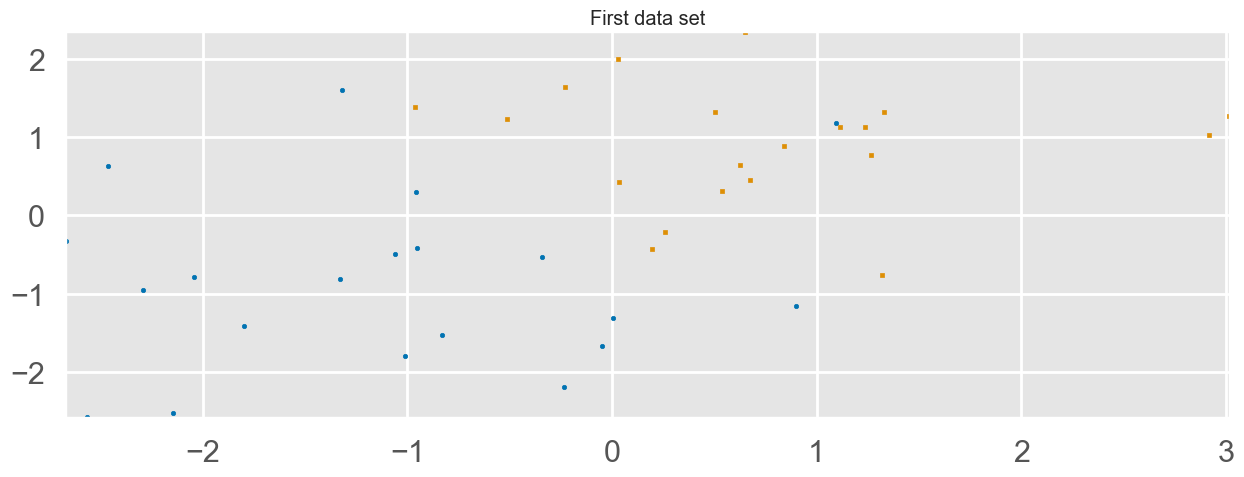

Score : 0.85


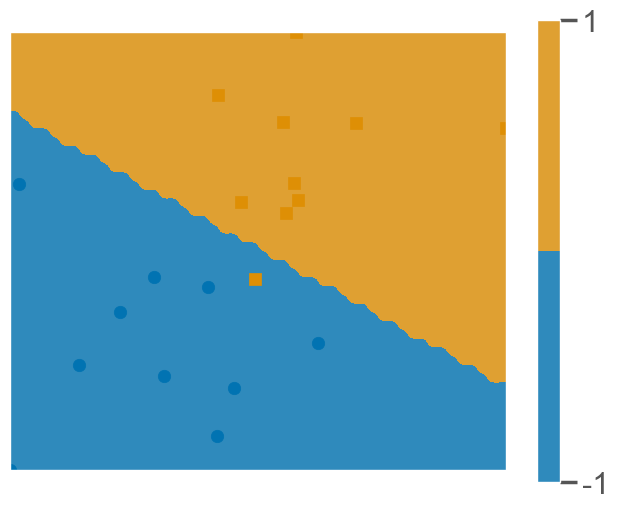

In [5]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)
plt.show()


X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

In [6]:

###############################################################################
#               Data Generation
###############################################################################

def mixtureGaussian(n,u1,u2,sigma1,sigma2) :
    X , y = make_blobs(n_samples = np.array([n,n]), n_features=2, centers = np.array([u1,u2]) ,cluster_std = np.array([sigma1,sigma2]), random_state=10)
    return(X,y)
    


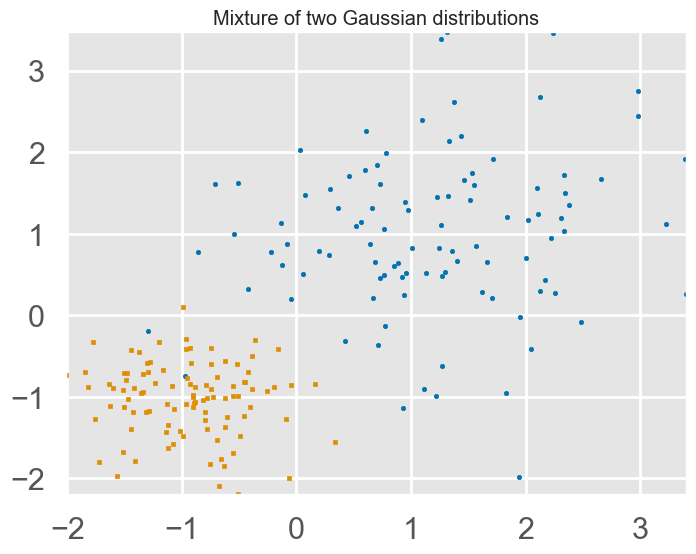

In [8]:
X , y = mixtureGaussian(100,[1,1],[-1,-1],[1,1],[0.5,0.5])
n = np.shape(X)[0]
X_train = X[:(3*n)//4]
y_train = y[:(3*n)//4]
X_test = X[(3*n)//4:]
y_test = y[(3*n)//4:]
plt.figure()
plt.title("Mixture of two Gaussian distributions")
plot_2d(X,y)
plt.show()

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [9]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

def eta(x,u1,u2,sigma1,sigma2) :
    cov1 = np.array([[sigma1[0],0],[0,sigma1[1]]])
    cov2 = np.array([[sigma2[0],0],[0,sigma2[1]]])
    f1 = multivariate_normal.pdf(x,mean = u1, cov = cov1 )
    f2 = multivariate_normal.pdf(x,mean = u2, cov = cov2 )
    return(f1/(f1 + f2))

def bayesest(x,u1,u2,sigma1,sigma2) :
    etax = eta(x,u1,u2,sigma1,sigma2)
    if (etax >= (1/2)) :
        return(0)
    else :
        return(1)

def montecarlo(ncarlo,u1,u2,sigma1,sigma2) :
    X_carlo , y_carlo = mixtureGaussian(ncarlo,u1,u2,sigma1,sigma2)
    s = 0
    for i in range(ncarlo) :
        s += bayesest(X_carlo[i],u1,u2,sigma1,sigma2)
        
    return(s/ncarlo)   

In [10]:
montecarlo(1000,[1,1],[-1,-1],[1,1],[0.5,0.5])

0.514

**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

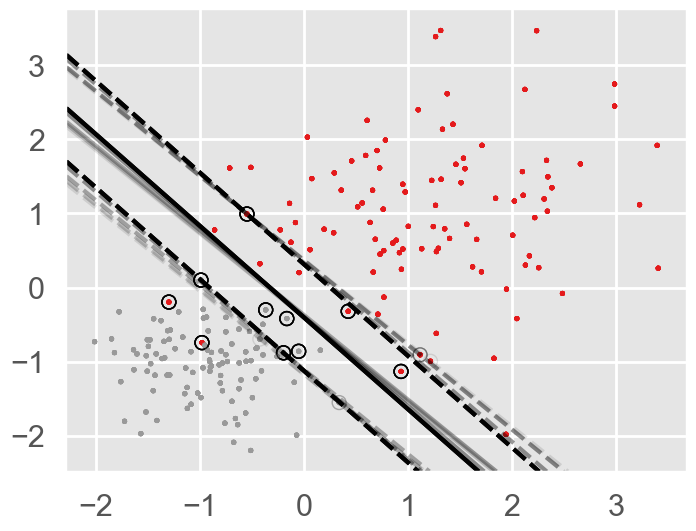

In [12]:
def cfunction(c,alpha) :

    clf = svm.SVC(kernel="linear", C=c)
    clf.fit(X_train, y_train)
    plt.scatter(X[:, 0], X[:, 1], c=y,s=10, cmap=plt.cm.Set1)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=alpha, linewidths = 3 , linestyles=["--", "-", "--"] )

    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        alpha = alpha,
        facecolors="none",
        edgecolors="k",
    )
    #plt.show()

    
clist = [1,2,3,4,5,10,100,1000]
nlist = len(clist)

plt.figure()
for i in range(1,nlist+1) :
    cfunction(clist[i-1],i/10)

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

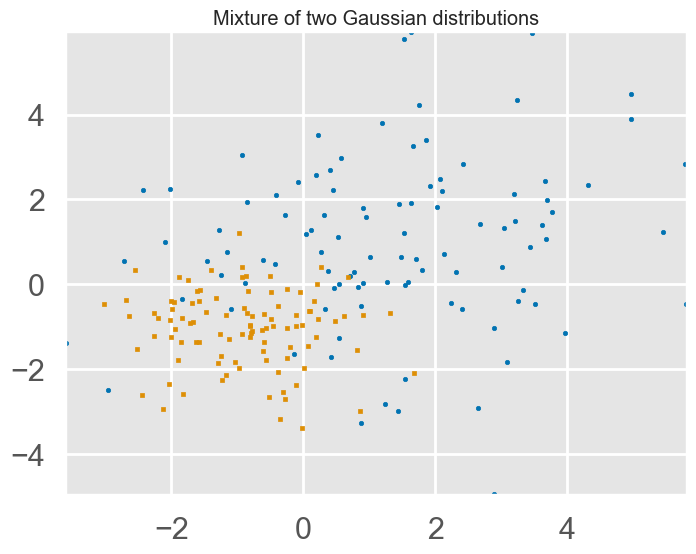

In [13]:
# Generate data and verify graphically that the two classes overlap
X1 , y1 = mixtureGaussian(100,[1,1],[-1,-1],[2,2],[1,1])
n = np.shape(X1)[0]
X_train1 = X1[:(3*n)//4]
y_train1 = y1[:(3*n)//4]
X_test1 = X1[(3*n)//4:]
y_test1 = y1[(3*n)//4:]
plt.figure()
plt.title("Mixture of two Gaussian distributions")
plot_2d(X1,y1)

SVC(C=0.012121212121212121, kernel='linear')


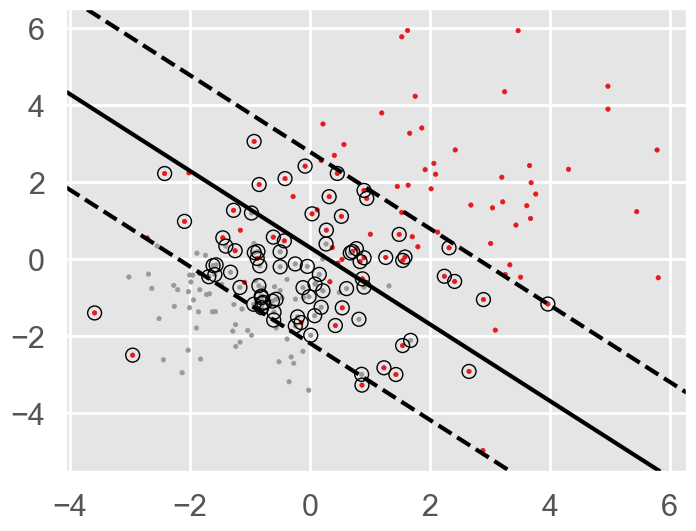

In [14]:
# Find the best working C with a 5-fold cross-validation
svc = svm.SVC(kernel="linear")
clf = GridSearchCV(svc, {"C" : np.linspace(0,0.1,100)})
clf.fit(X_train1 , y_train1)
print(clf.best_estimator_)
copt = clf.best_params_['C']

#Plot the results

plt.figure()
clf = svm.SVC(kernel="linear", C=copt)
clf.fit(X_train1, y_train1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1,s=10, cmap=plt.cm.Set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], linewidths = 3 , linestyles=["--", "-", "--"] )

ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

SVC(C=0.5263157894736842, gamma=0.5263157894736842)


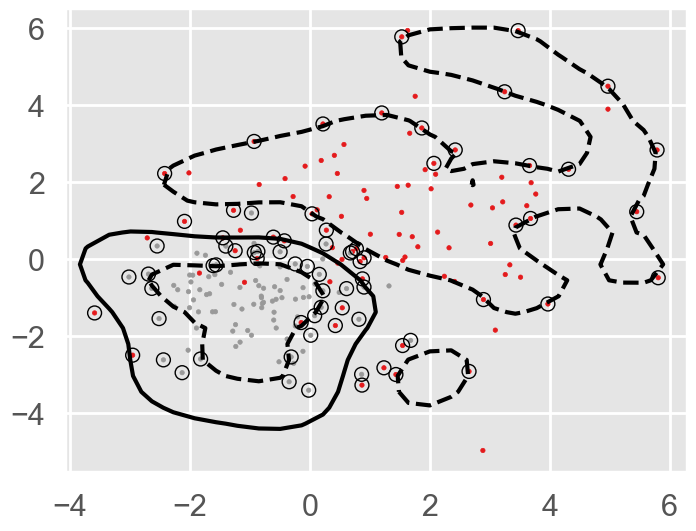

In [15]:
# Vary the parameter of the kernel and check the difference between training and testing scores
svc = svm.SVC(kernel="rbf")
clf = GridSearchCV(svc, {"gamma":np.linspace(0,10,20),"C" : np.linspace(0,10,20)})
clf.fit(X_train1 , y_train1)
print(clf.best_estimator_)
copt = clf.best_params_['C']
gopt = clf.best_params_['gamma']

#Plot the results

plt.figure()
clf = svm.SVC(kernel="rbf", C=copt,gamma=gopt)
clf.fit(X_train1, y_train1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1,s=10, cmap=plt.cm.Set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], linewidths = 3 , linestyles=["--", "-", "--"] )

ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

In [16]:
sigma = 0.1
n = 1000
X2, y2 = make_circles(n,noise=0.1,factor=0.7)
X_train2 = X2[:(3*n)//4]
y_train2 = y2[:(3*n)//4]
X_test2 = X2[(3*n)//4:]
y_test2 = y2[(3*n)//4:]


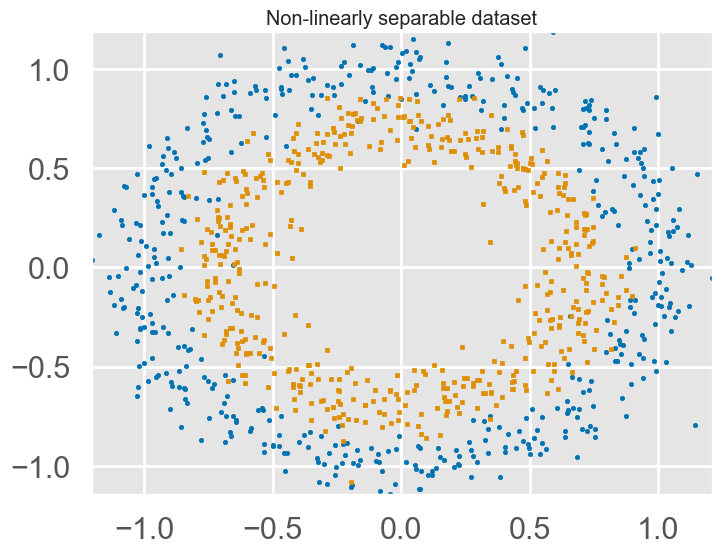

In [17]:
plt.figure()
plot_2d(X2,y2)
plt.title("Non-linearly separable dataset")
plt.show()

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

SVC(C=0.5263157894736842, gamma=7.894736842105263)


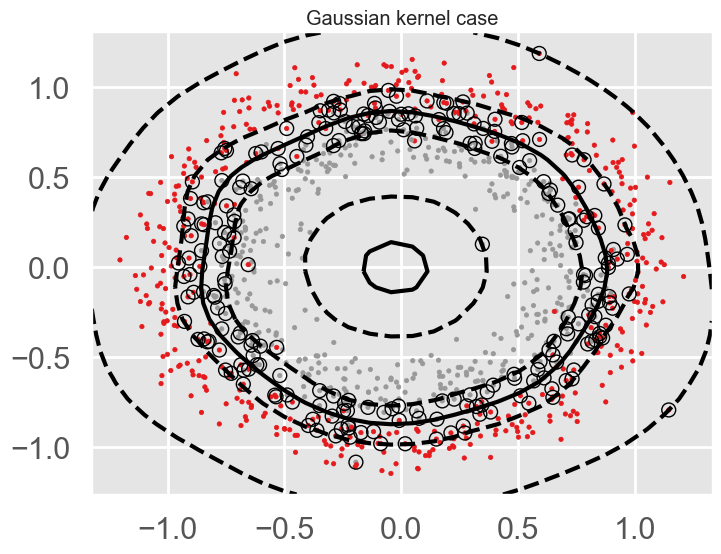

In [18]:
svc = svm.SVC(kernel="rbf")
clf = GridSearchCV(svc, {"gamma":np.linspace(0,10,20),"C" : np.linspace(0,10,20)})
clf.fit(X_train2 , y_train2)
print(clf.best_estimator_)
copt = clf.best_params_['C']
gopt = clf.best_params_['gamma']

#Plot the results

plt.figure()
clf = svm.SVC(kernel="rbf", C=copt,gamma=gopt)
clf.fit(X_train2, y_train2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2,s=10, cmap=plt.cm.Set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], linewidths = 3 , linestyles=["--", "-", "--"] )

ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title("Gaussian kernel case")
plt.show()

SVC(C=5.263157894736842, degree=2, kernel='poly')


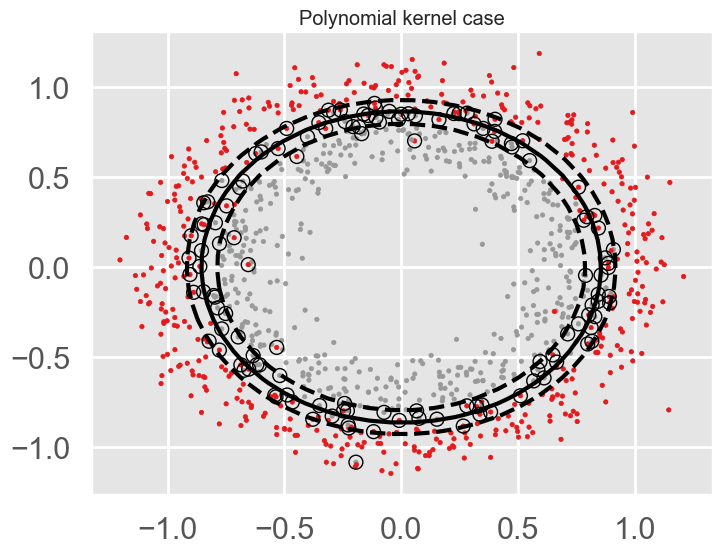

In [19]:
svc = svm.SVC(kernel="poly")
clf = GridSearchCV(svc, {"degree":[i for i in range(10)],"C" : np.linspace(0,10,20)})
clf.fit(X_train2 , y_train2)
print(clf.best_estimator_)
copt = clf.best_params_['C']
dopt = clf.best_params_['degree']

#Plot the results

plt.figure()
clf = svm.SVC(kernel="poly", C=copt,degree=dopt)
clf.fit(X_train2, y_train2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2,s=10, cmap=plt.cm.Set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], linewidths = 3 , linestyles=["--", "-", "--"] )

ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title("Polynomial kernel case")
plt.show()

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

Given a dataset, perform all three methods with the best parameters given by the function GridSearchCV and compare their scores on the test set. Repeat for several types of datasets (linarly separable or not...etc) to determine on each occasion, each model is the best.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

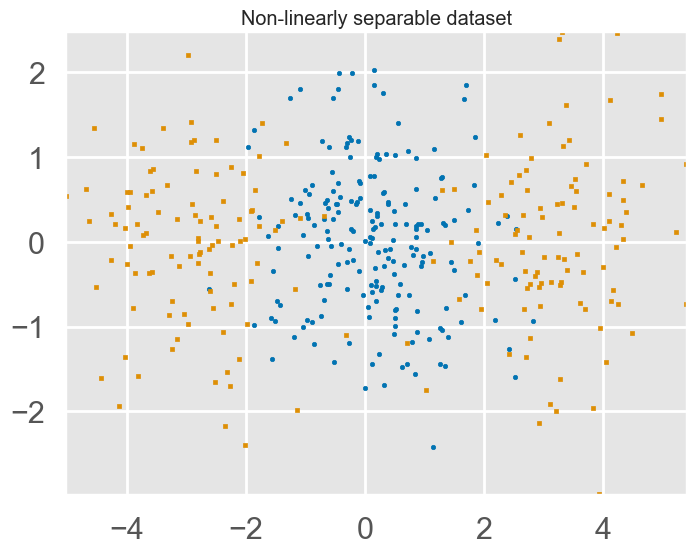

In [20]:
def NLS(n,u1,u2,u3,sigma1,sigma2,sigma3) :
    X , y = mixtureGaussian(n,u1,u2,sigma1,sigma2)
    y = np.ones(2*n)

    Xtemp , ytemp = make_blobs(n_samples = np.array([2*n]), n_features=2, centers = np.array([u3]) ,cluster_std = np.array([sigma3]))

    X = np.concatenate((X,Xtemp))
    y = np.concatenate((y,ytemp))

    X, y = shuffle(X, y)
    return(X,y)

X3 , y3 = NLS(100,np.array([3,0]),np.array([-3,0]),np.array([0,0]),np.array([1,1]),np.array([1,1]),np.array([1,1])) 

X_train3 = X3[:(3*n)//4]
y_train3 = y3[:(3*n)//4]
X_test3 = X3[(3*n)//4:]
y_test3 = y3[(3*n)//4:]
plt.figure()
plt.title("Non-linearly separable dataset")
plot_2d(X3,y3)



In [21]:
def eta2(x,u1,u2,u3,sigma1,sigma2,sigma3) :
    cov1 = np.array([[sigma1[0],0],[0,sigma1[1]]])
    cov2 = np.array([[sigma2[0],0],[0,sigma2[1]]])
    cov3 = np.array([[sigma3[0],0],[0,sigma3[1]]])
    f1 = multivariate_normal.pdf(x,mean = u3, cov = cov3 )
    f2 = multivariate_normal.pdf(x,mean = u2, cov = cov2 ) + multivariate_normal.pdf(x,mean = u1, cov = cov1 )
    return(f1/(f1 + f2))

def bayesest2(x,u1,u2,u3,sigma1,sigma2,sigma3) :
    etax = eta2(x,u1,u2,u3,sigma1,sigma2,sigma3)
    if (etax >= (1/2)) :
        return(0)
    else :
        return(1)


SVC(C=1.5789473684210527, degree=2, kernel='poly')


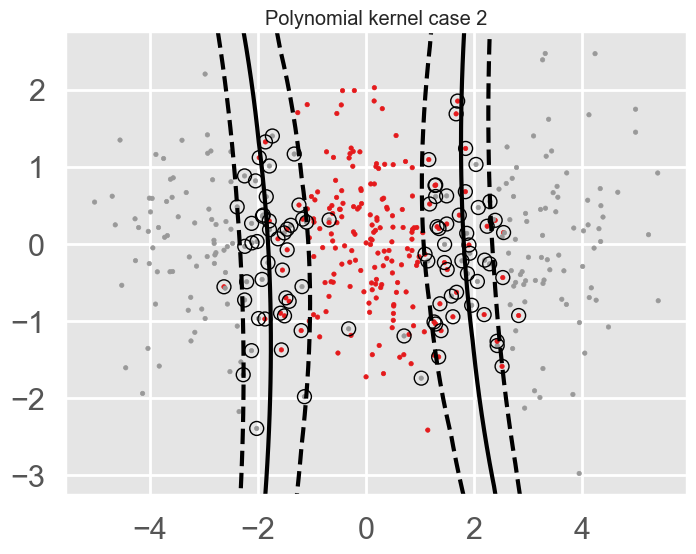

In [22]:
svc = svm.SVC(kernel="poly")
clf = GridSearchCV(svc, {"degree":[i for i in range(10)],"C" : np.linspace(0,10,20)})
clf.fit(X_train3 , y_train3)
print(clf.best_estimator_)
copt = clf.best_params_['C']
dopt = clf.best_params_['degree']

#Plot the results

plt.figure()
clf = svm.SVC(kernel="poly", C=copt,degree=dopt)
clf.fit(X_train3, y_train3)
plt.scatter(X3[:, 0], X3[:, 1], c=y3,s=10, cmap=plt.cm.Set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], linewidths = 3 , linestyles=["--", "-", "--"] )

ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title("Polynomial kernel case 2")
plt.show()

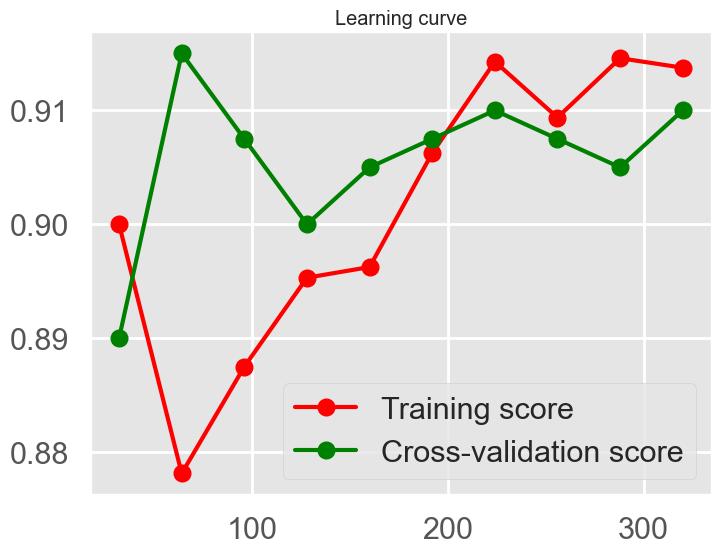

In [23]:
train_sizes, train_scores, test_scores = learning_curve(  SVC(kernel="poly",C=copt,degree=dopt),
        X3,
        y3,
        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


# Plot learning curve
plt.figure()
plt.plot(
    train_sizes, train_scores_mean , "o-", color="r", label="Training score"
)

plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend()
plt.title('Learning curve')
plt.show()

In [24]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

def montecarlo2(ncarlo,u1,u2,u3,sigma1,sigma2,sigma3) :
    X_carlo , y_carlo = NLS(ncarlo,u1,u2,u3,sigma1,sigma2,sigma3)
    s = 0
    for i in range(ncarlo) :
        s += bayesest2(X_carlo[i],u1,u2,u3,sigma1,sigma2,sigma3)
        
    return(s/ncarlo)

montecarlo2(100,np.array([3,0]),np.array([-3,0]),np.array([0,0]),np.array([1,1]),np.array([1,1]),np.array([1,1]))

0.49

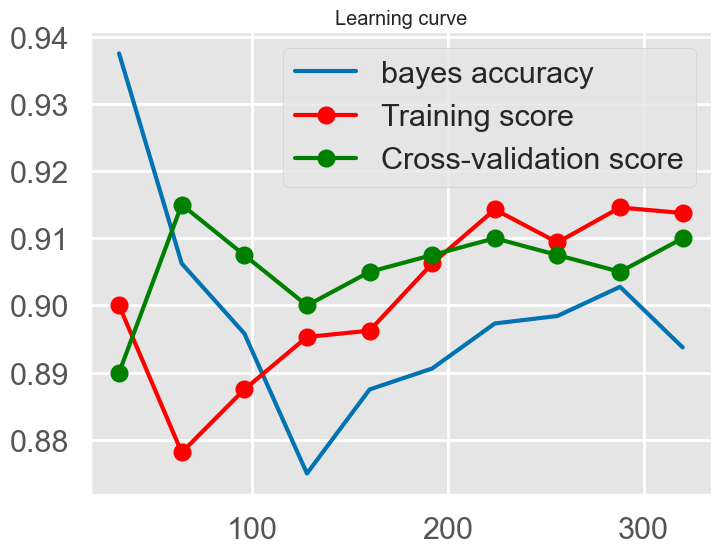

In [25]:
# Add this estimation to the plot of train/test error
bayes = np.zeros(np.shape(train_sizes)[0])
n = np.shape(X3)[0]
for i in range(np.shape(train_sizes)[0]) :
    for j in range(train_sizes[i]):
        y_test = bayesest2(X3[j%n],np.array([3,0]),np.array([-3,0]),np.array([0,0]),np.array([1,1]),np.array([1,1]),np.array([1,1]))
        if(y_test == y3[j%n]) :
            bayes[i] += 1
    bayes[i] = bayes[i]/train_sizes[i]
    
# Plot learning curve
plt.figure()
plt.plot(train_sizes,bayes,label="bayes accuracy")
plt.plot(
    train_sizes, train_scores_mean , "o-", color="r", label="Training score"
)

plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend()
plt.title('Learning curve')
plt.show()


**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


In [26]:
# Modify the class of some data points randomly
import random
N = len(y3)
noise_nb=N//5
noise_labels = random.sample(range(N), noise_nb)
for i in noise_labels:
    y3[i]=(y3[i]+1)%2


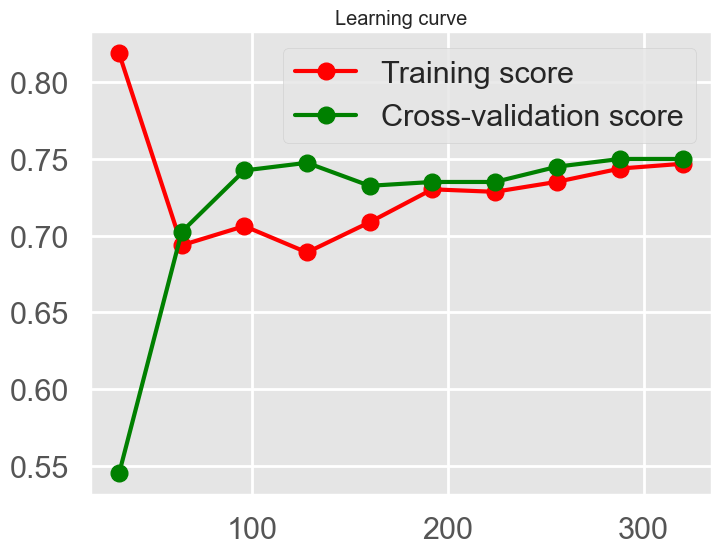

In [27]:
train_sizes, train_scores, test_scores = learning_curve(  SVC(kernel="poly",C=copt,degree=dopt),
        X3,
        y3,
        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


# Plot learning curve
plt.figure()
plt.plot(
    train_sizes, train_scores_mean , "o-", color="r", label="Training score"
)

plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend()
plt.title('Learning curve')
plt.show()


The training score is worse.

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regularization parameter C.

The script returned an error (about an -f option) and caused problems with matplotlib plot.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

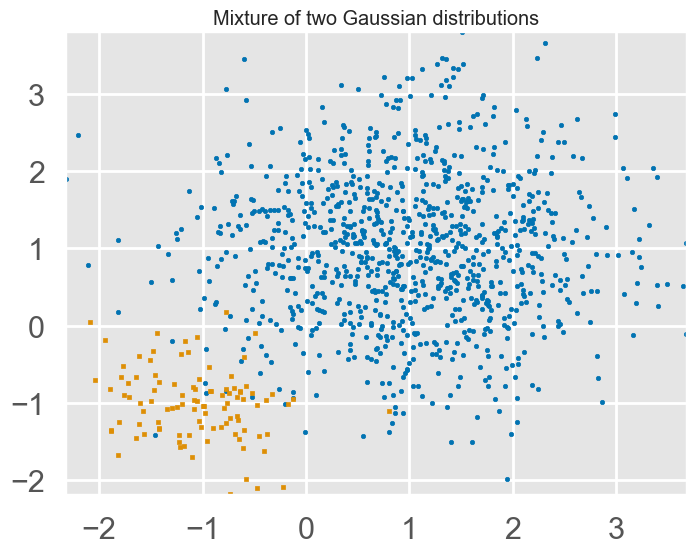

In [28]:
def mixtureGaussian2(n1,n2,u1,u2,sigma1,sigma2) :
    X , y = make_blobs(n_samples = np.array([n1,n2]), n_features=2, centers = np.array([u1,u2]) ,cluster_std = np.array([sigma1,sigma2]), random_state=10)
    return(X,y)
X4 , y4 = mixtureGaussian2(1000,100,[1,1],[-1,-1],[1,1],[0.5,0.5])
n = np.shape(X4)[0]
X_train4 = X4[:(3*n)//4]
y_train4 = y4[:(3*n)//4]
X_test4 = X4[(3*n)//4:]
y_test4 = y4[(3*n)//4:]
plt.figure()
plt.title("Mixture of two Gaussian distributions")
plot_2d(X4,y4)

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

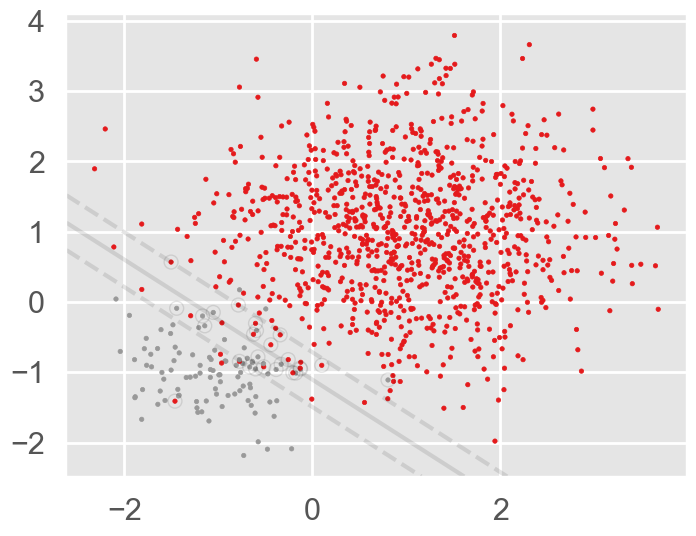

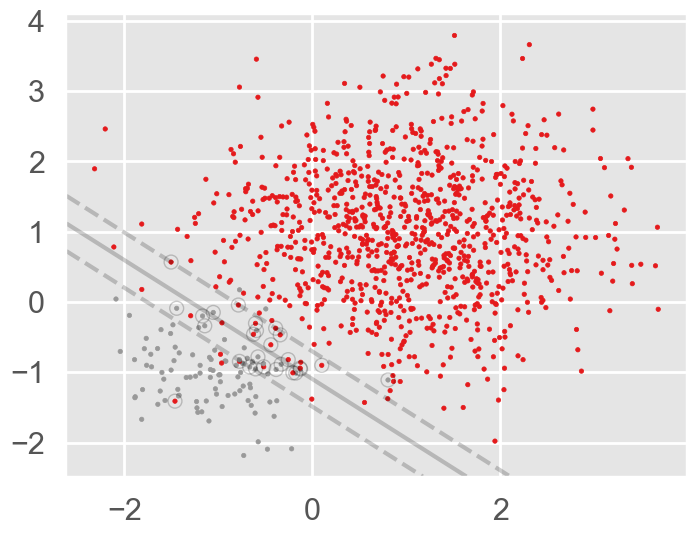

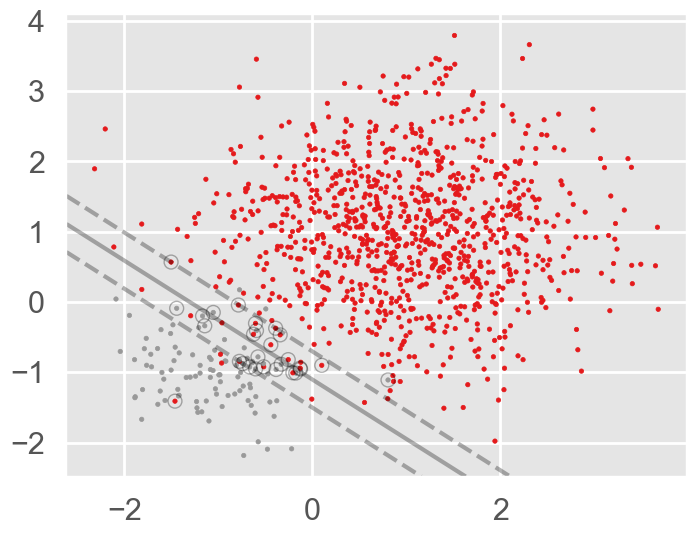

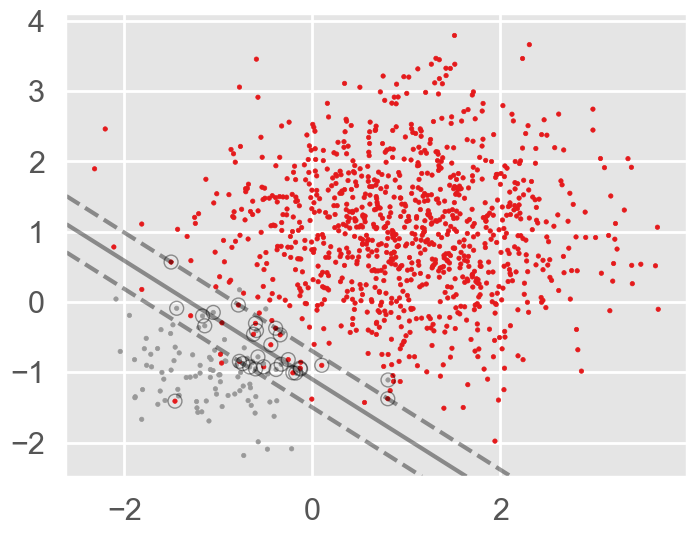

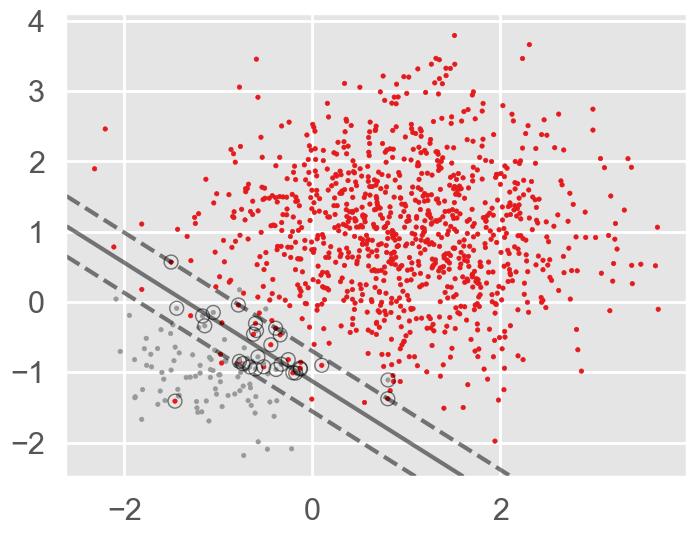

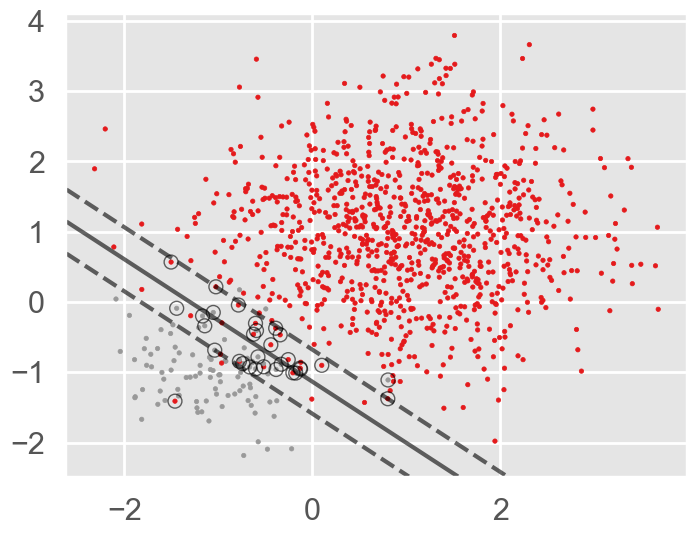

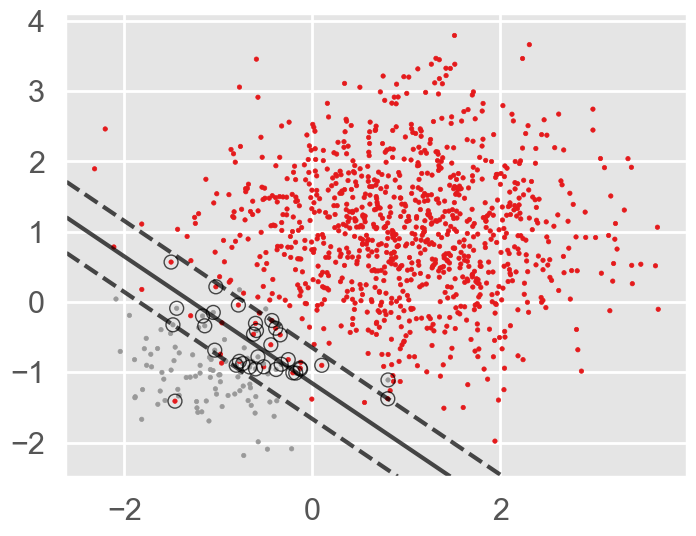

In [29]:
def cfunction2(c,alpha) :

    clf = svm.SVC(kernel="linear", C=c)
    clf.fit(X_train4, y_train4)
    plt.scatter(X4[:, 0], X4[:, 1], c=y4,s=10, cmap=plt.cm.Set1)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour( XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=alpha, linewidths = 3 , linestyles=["--", "-", "--"] )

    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        alpha = alpha,
        facecolors="none",
        edgecolors="k",
    )
    plt.show()

    
clist = [100,10,5,4,3,2,1]
nlist = len(clist)

plt.figure()
for i in range(1,nlist+1) :
    cfunction2(clist[i-1],i/10)

## Going further : application to face classification

Code for downloading and organizing the data:

In [2]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = [ 'Tony Blair','Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))

images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int32)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

Fitting the classifier to the training set


<IPython.core.display.Javascript object>


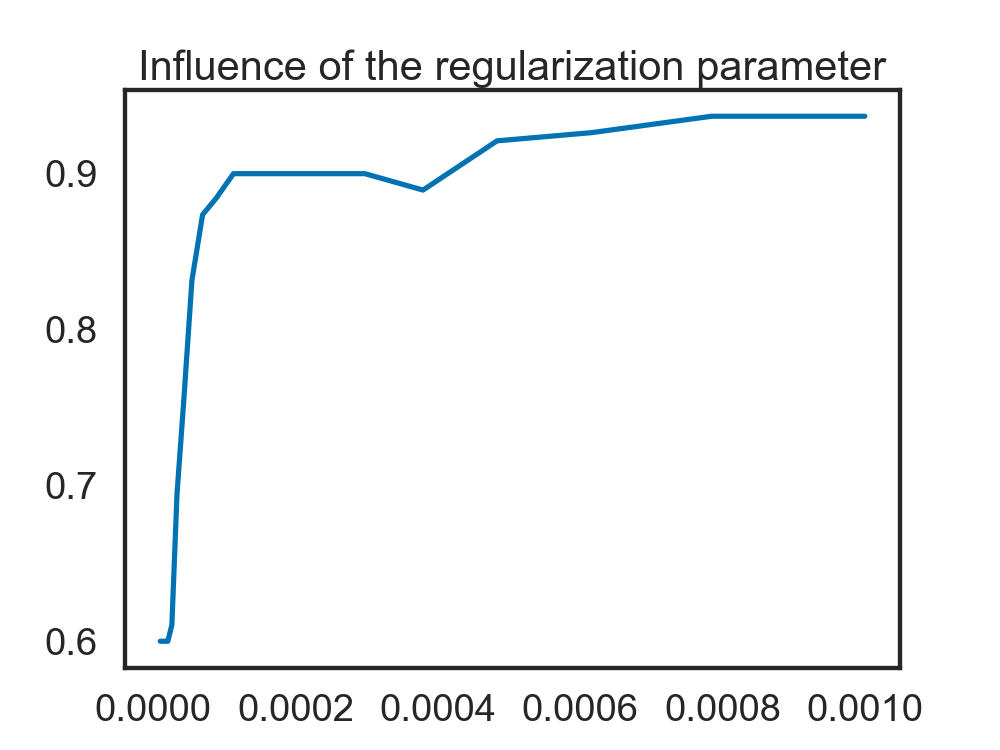

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

yaxe = []
c = np.logspace(-5,-3,num=20,base=10.0)
for i in c:
    clf = svm.SVC(kernel="linear",C=i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    yaxe+=[score]
plt.figure()
plt.plot(c,yaxe)
plt.title("Influence of the regularization parameter")
plt.show()

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.094s
Chance level : 0.6210526315789474
Accuracy : 0.9368421052631579


<IPython.core.display.Javascript object>


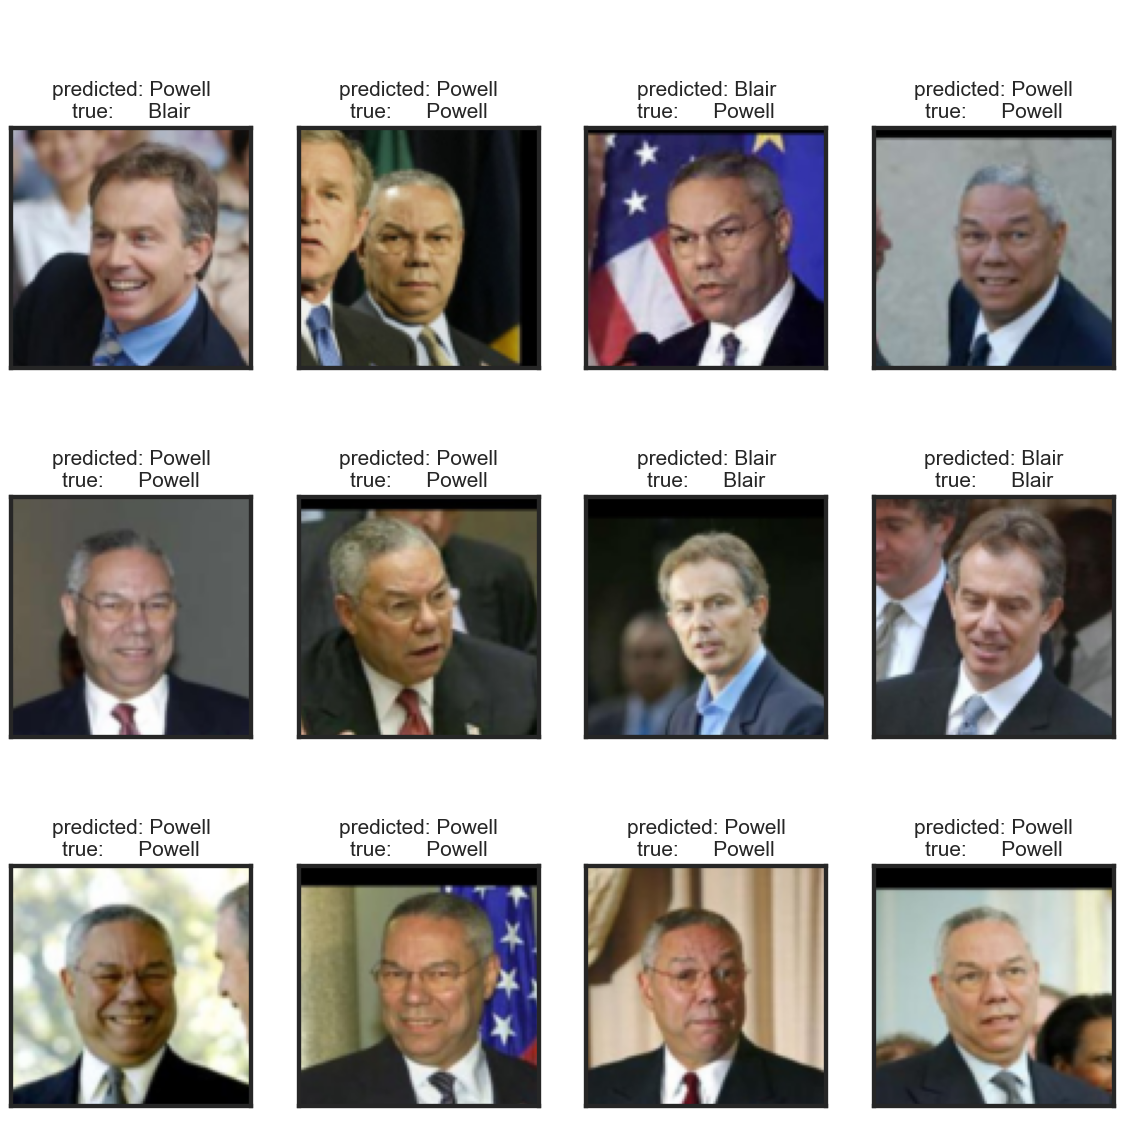

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

**18)** Explain why the features are centered and reduced.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

Fitting the classifier to the training set


<IPython.core.display.Javascript object>


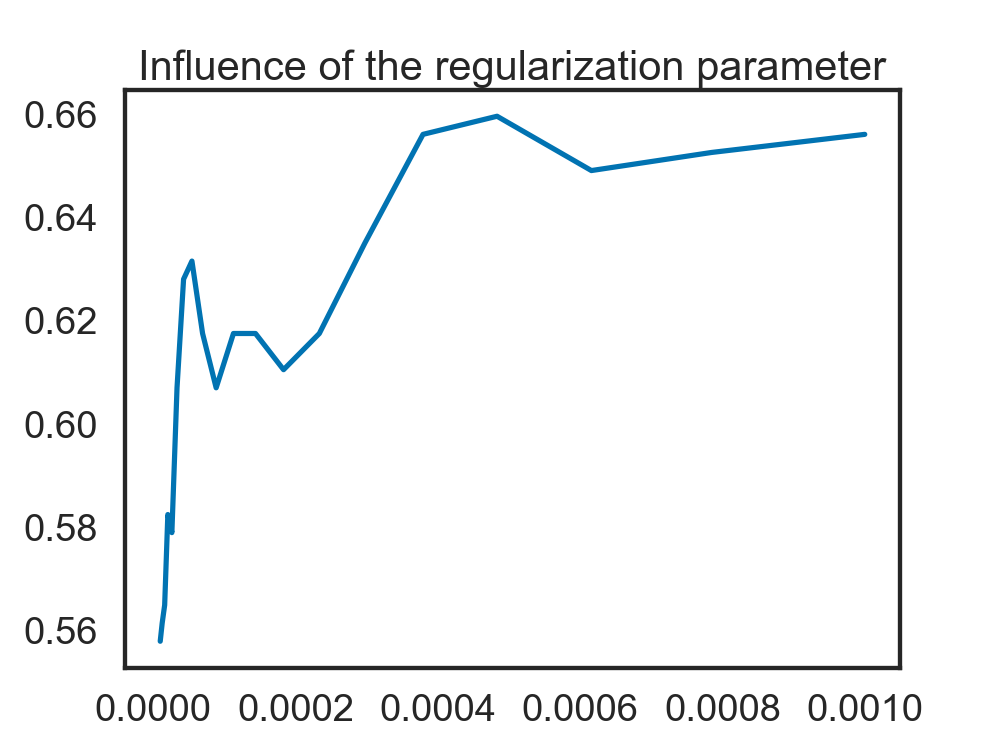

Predicting the people names on the testing set
done in 0.265s
Chance level : 0.5403508771929825
Accuracy : 0.656140350877193


In [ ]:
X0 = np.concatenate((X,X[::2,:]))

ytemp = y[::2]

for i in range(len(ytemp)) :
    ytemp[i] = (ytemp[i]+1)%2
y0 = np.concatenate((y,ytemp))

indices = np.random.permutation(X0.shape[0])
train_idx, test_idx = indices[:int(X0.shape[0] / 2)], indices[int(X0.shape[0] / 2):]
X_train, X_test = X0[train_idx, :], X0[test_idx, :]
y_train, y_test = y0[train_idx], y0[test_idx]

####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

yaxe = []
c = np.logspace(-5,-3,num=20,base=10.0)
for i in c:
    clf = svm.SVC(kernel="linear",C=i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    yaxe+=[score]
plt.figure()
plt.plot(c,yaxe)
plt.title("Influence of the regularization parameter")
plt.show()

print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y0), 1. - np.mean(y0)))
print("Accuracy : %s" % clf.score(X_test, y_test))

There is a big drop in accuracy

18) The features have to be normalized to apply the PCA independently from the mean and variance.

In [ ]:
indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

svc = svm.SVC(kernel="rbf")
clf = GridSearchCV(svc, {"gamma":np.linspace(0,10,20),"C" : np.linspace(0,10,20)})
clf.fit(X_train1 , y_train1)
print(clf.best_estimator_)
copt = clf.best_params_['C']
gopt = clf.best_params_['gamma']

clf = svm.SVC(kernel="rbf",C=copt,gamma=gopt)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)


print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Fitting the classifier to the training set
SVC(C=0.5263157894736842, gamma=0.5263157894736842)
Predicting the people names on the testing set
done in 0.403s
Chance level : 0.5
Accuracy : 0.4842105263157895


The Gaussian kernel gives a accuracy far worse than the linear kernel. In that case, the linear kernel is better.